# Clasificador de imágenes. Red convolucional

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds



In [2]:
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

In [3]:
metadatos

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_path='C:\\Users\\dekad\\tensorflow_datasets\\fashion_mnist\\3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
  

In [4]:
datos_entrenamiento = datos['train']
datos_pruebas = datos['test']

In [5]:
nombres_clases = metadatos.features['label'].names

In [6]:
nombres_clases

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
# Normalizar los datos ( pasar de 0-255 a 0-1)
def normalizar(imagenes, etiquetas):
    imagenes = tf.cast(imagenes, tf.float32)
    imagenes /= 255 #aquí pasamos de 0-255 a 0-1
    return imagenes, etiquetas

# Normalizar los datos de entrenamiento y pruebas por la función anterior
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#Agregar a caché (usar memoria en lugar de disco, hace que el entrenamiento sea más rápido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

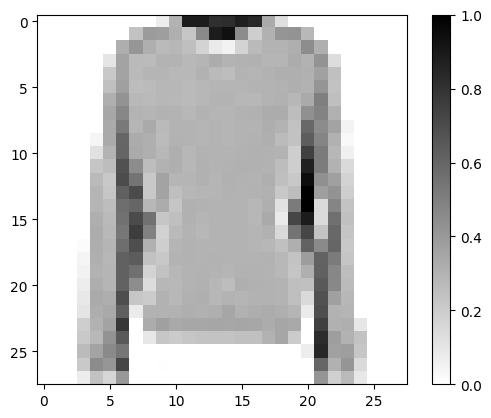

In [8]:
# Mostrar una imagen de los datos de prueba, usaremos la número 3
# datos_entrenamiento = datos_entrenamiento.shuffle(10000)
for imagen, etiqueta in datos_entrenamiento.take(1):
    break
imagen = imagen.numpy().reshape((28,28)) #redimensionar la imagen

import matplotlib.pyplot as plt

# Dibujar imagen
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

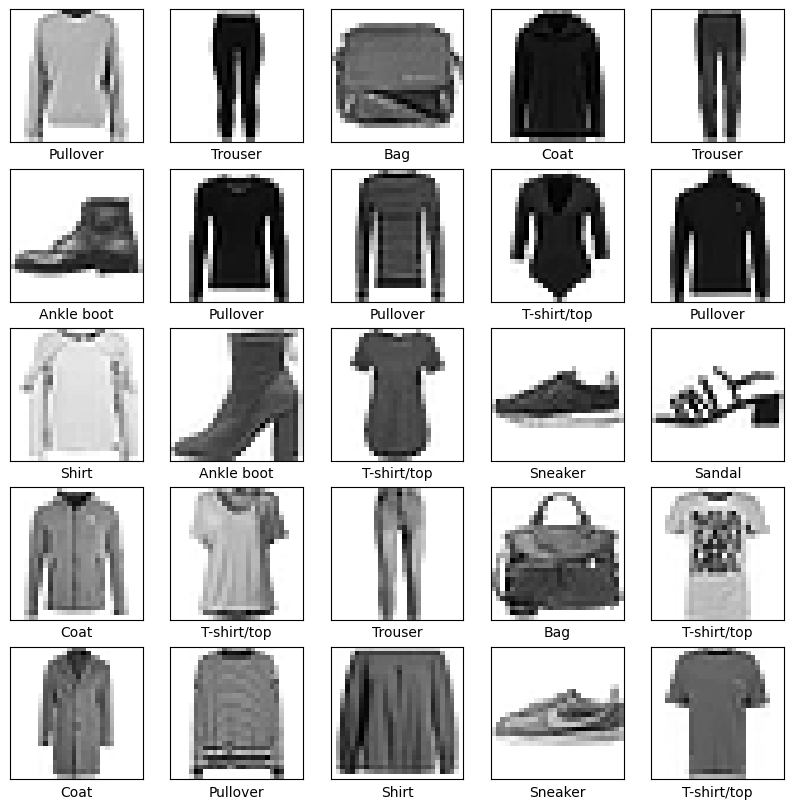

In [9]:
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
    imagen = imagen.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imagen, cmap=plt.cm.binary)
    plt.xlabel(nombres_clases[etiqueta])
plt.show()

In [10]:
# Crear el modelo

modelo = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(28,28,1)), # 1 - Blanco y negro
   tf.keras.layers.Dense(50, activation=tf.nn.relu),
   tf.keras.layers.Dense(50, activation=tf.nn.relu),
   tf.keras.layers.Dense(10, activation=tf.nn.softmax) # función para clasificar imágenes
])

In [11]:
# Compilar el modelo

modelo.compile(
   optimizer='adam',
   loss=tf.keras.losses.SparseCategoricalCrossentropy(),
   metrics=['accuracy']
)

In [12]:
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples

In [13]:
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [14]:
TAMANO_LOTE = 32

datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [15]:
import math

#Entrenar

historial = modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch=math.ceil(num_ej_entrenamiento/TAMANO_LOTE))


Epoch 1/5



1875/1875 [==============================] - 8s 3ms/step - loss: 0.5118 - accuracy: 0.8182
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3827 - accuracy: 0.8623
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3494 - accuracy: 0.8723
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3274 - accuracy: 0.8801
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3114 - accuracy: 0.8860


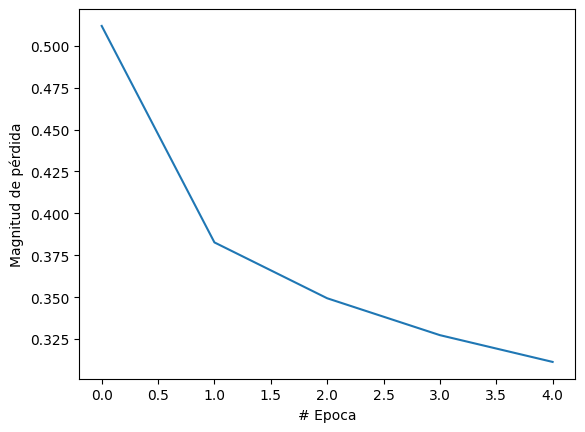

In [16]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])

1/1 [==============================] - 0s 154ms/step


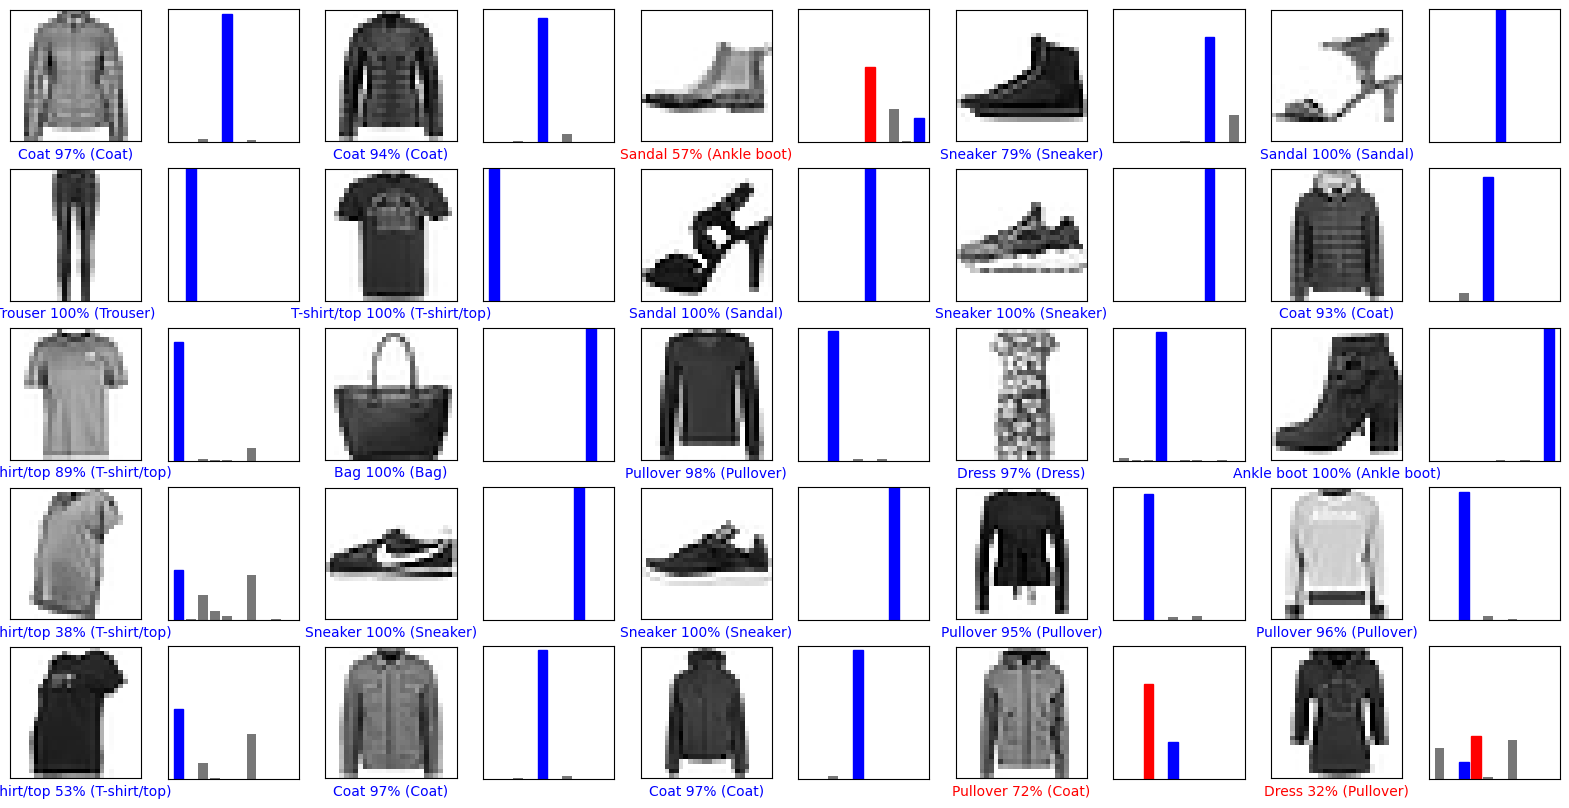

In [17]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)
  
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)
  
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')
  
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

In [18]:
#Probar una imagen suelta
imagen = imagenes_prueba[4] #AL ser la variable imagenes_prueba solo tiene lo que se le puso en el bloque anterior
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Prediccion: " + nombres_clases[np.argmax(prediccion[0])])

1/1 [==============================] - 0s 77ms/step
Prediccion: Sandal
